# Аналитика в Яндекс.Афише

## Постановка задачи

В качестве стажировки в Яндекс.Афише требуется помочь маркетологам оптимизировать маркетинговые затраты.

В нашем распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
* лог сервера с данными о посещениях сайта Яндекс.Афиши,
* выгрузка всех заказов за этот период,
* статистика рекламных расходов.

Нужно определить:
* как люди пользуются продуктом,
* когда они начинают покупать,
* сколько денег приносит каждый клиент
* когда клиент окупается.

## Описание данных

* Таблица visits (лог сервера с информацией о посещениях сайта)
* Таблица orders (информация о заказах)
* Таблица costs (информация о затратах на маркетинг)


## Шаг 1. Подготовка данных к анализу

Импортируем необходимые для анализа библиотеки.

In [1]:
import pandas as pd

In [2]:
import numpy as np

### Информация о посещениях сайта

Прочитаем в датафрейм лог с сервера, содержащий информацию о посещениях сайта.

In [3]:
visits = pd.read_csv('datasets/visits_log.csv')
visits.head(10)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


Переименуем столбцы для удобства работы.

In [4]:
visits.columns = ['device','end_ts', 'source_id', 'start_ts', 'uid']

Изучим общую инофрмацию о файле.

In [5]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null object
source_id    359400 non-null int64
start_ts     359400 non-null object
uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Пропущенных значений нет. Начало и конец сессии приведем к формату дат.

In [6]:
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format="%Y-%m-%d %H:%M")
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format="%Y-%m-%d %H:%M")
visits.dtypes

device               object
end_ts       datetime64[ns]
source_id             int64
start_ts     datetime64[ns]
uid                  uint64
dtype: object

### Иноформация о заказах

Прочитаем в датафрейм файл с данными о заказах за тот же период.

In [7]:
orders = pd.read_csv('datasets/orders_log.csv')
orders.head(10)

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


Переименуем столбцы для удобства работы.

In [8]:
orders.columns = ['buy_ts', 'revenue', 'uid']

Изучим общую информацию о файле.

In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null object
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


По количеству строк видим, что заказов точно было меньше, чем пользователей, что реалистично. Пропущенных значений нет, а дату покупки следует привести к подходящему формату.

In [10]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format="%Y-%m-%d %H:%M")
orders.dtypes

buy_ts     datetime64[ns]
revenue           float64
uid                uint64
dtype: object

С заказами пока все.

### Затраты на маркетинг

Прочитаем в датафрейм файл со статистикой рекламных расходов.

In [11]:
costs = pd.read_csv('datasets/costs.csv')
costs.head(10)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


У нас нет расшифровок рекламных источников и единиц, в которых измеряются затраты. Видимо, Яндекс.Афиша не очень-то доверяет своим стажерам. Будем предполагать, что затраты в тысячах рублей. Это вполне соотносится со стоимостью заказов из таблицы orders, где 0.37 может быть 370 рублями за билет в кино, а 3.30 - это 3300 рублей за пару билетов на концерт. Что касается рекламных источников, будем рассчитывать, что они хотя бы совпадают с источниками из таблицы visits. 

Дадим столбцу dt более осознанное название на случай, если нам придется соединять таблицы.

In [12]:
costs.columns = ['source_id', 'cost_ts', 'costs']

Изучим общую информацию о файле.

In [13]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
cost_ts      2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Скорректируем формат даты.

In [14]:
costs['cost_ts'] = pd.to_datetime(costs['cost_ts'], format="%Y-%m-%d")
costs.dtypes

source_id             int64
cost_ts      datetime64[ns]
costs               float64
dtype: object

### Вывод

Были загружены данные о визитах, заказах и расходах в переменные. Данные были оптимизированы для анализа.

## Шаг 2. Построение отчетов и расчет метрик

## Продукт

Ответим на следующие вопросы:
* Сколько людей пользуются в день, неделю, месяц?
* Сколько сессий в день?
* Сколько длится одна сессия?
* Как часто люди возвращаются?

### Оценка пользовательской активности

Изучим, сколько людей пользуются продуктом. Выделим в отдельные столбцы год, месяц и неделю, а также полную дату визита пользователя.

In [15]:
visits['session_year']  = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week']  = visits['start_ts'].dt.week
visits['session_date'] = visits['start_ts'].dt.date
visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27


Рассчитаем количество уникальных пользователей в день: сгруппируем данные по уникальным пользователям и найдём среднее.

In [16]:
dau_total = visits.groupby('session_date').agg({'uid': 'nunique'}).mean()
dau_total

uid    907.991758
dtype: float64

Рассчитаем количество уникальных пользователей в неделю.

In [17]:
wau_total = visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean()
wau_total

uid    5716.245283
dtype: float64

Рассчитаем количество уникальных пользователей в месяц.

In [18]:
mau_total = visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean()
mau_total

uid    23228.416667
dtype: float64

Получили DAU = 907.99, WAU = 5716.25, MAU = 23228.42. Скромные цифры для продукта вроде Яндекс.Афиши. Есть куда расти.


Оценим пользовательскую активность в разрезе устройств, с которых используют продукт. Посмотрим, какие устройства выделены в имеющейся выгрузке.

In [19]:
visits['device'].unique()

array(['touch', 'desktop'], dtype=object)

В наших данных логи посещений сайта Афиши, поэтому touch - это заход с мобильного браузера.

Построим график для MAU, так как за период в год это наиболее удобная форма оценки.

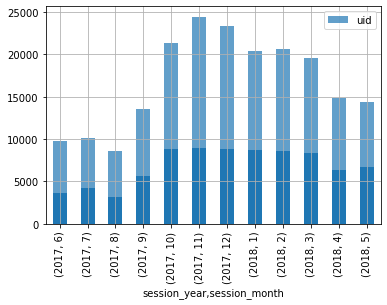

In [20]:
visits.query('device == "touch"').groupby(['session_year', 'session_month'])['uid'].nunique().plot(kind='bar')
visits.query('device == "desktop"').groupby(['session_year', 'session_month'])['uid'].nunique().plot(kind='bar',alpha=0.7, 
                                                                                                     grid=True, legend=True)

Месячная аудитория десктопа превышает аудиторию мобильных устройств более чем в 2 раза, и это соотношение примерно сохраняется на протяжении периода. Похоже на правду, так как обычно мобильные версии не так удобны как полноценные либо приложения, но позволяют пользователям решать простейшие задачи. Для обоих типов устройств характерно повышение активности в холодное время года.

Рассчитаем числовые значения MAU по платформам.

In [21]:
mau_desktop = visits.query('device == "desktop"').groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean()
mau_desktop

uid    16724.916667
dtype: float64

In [22]:
mau_touch = visits.query('device == "touch"').groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean()
mau_touch

uid    6825.916667
dtype: float64

Разница в месячной аудитории в среднем 2,5 раза.

### Пользовательская сессия

Изучим, сколько сессий в день приходится на одного пользователя.

In [23]:
sessions_per_user = visits.groupby('session_date').agg({'uid': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
sessions_per_user.head()

,n_sessions,n_users,sessions_per_user
session_date,,,
2017-06-01,664,605,1.097521
2017-06-02,658,608,1.082237
2017-06-03,477,445,1.071910
2017-06-04,510,476,1.071429
2017-06-05,893,820,1.089024


Получили данные за каждую дату. Посчитаем среднюю величину.

In [24]:
sessions_per_user['sessions_per_user'].mean()

1.082169644003972

В среднем пользователи заходят на сайт по по 1 разу в день. В принципе, для покупки билетов на мероприятие пользователю этого достаточно.

### Средняя продолжительность сессии

Рассчитаем среднюю продолжительность сессии. Добавим столбец с длительностью каждой сессии и рассчитаем среднее по нему.

In [25]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
visits['session_duration_sec'].mean()

643.506488592098

В среднем пользователи проводят на сайте 10 минут. Достаточно для того, чтобы повыбирать, куда сходить.

Оценим распределение величины.

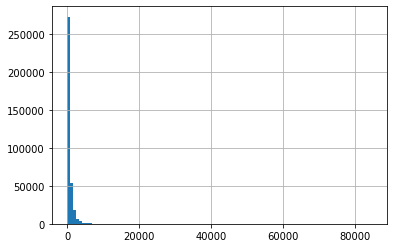

In [26]:
visits['session_duration_sec'].hist(bins=100)

Распределение не похоже на нормальное, поэтому для итоговой оценки воспользуемся модой.

In [27]:
asl = visits['session_duration_sec'].mode()
asl

0    60
dtype: int64

А вот за 60 секунд можно успеть купить билет, если выбор уже сделан заранее. Либо можно потыкать мобильную версию сайта и найти кнопку "скачать приложение". Рассмотрим среднюю продолжительность сессии в зависимости от платформы. Оценим моду.

In [28]:
asl_touch_mode = visits.query('device == "touch"')['session_duration_sec'].mode()
asl_touch_mode

0    60
dtype: int64

In [29]:
asl_desktop_mode = visits.query('device == "desktop"')['session_duration_sec'].mode()
asl_desktop_mode

0    60
dtype: int64

Характерная продолжительность сессии в 60 секунд не зависит от платформы. Стоило бы предложить коллегам изучить их детально, например, с помощью тепловой карты кликов.

Сравним средние значения длительности сессии - эти параметры скорее всего будут различаться.

In [30]:
asl_touch = visits.query('device == "touch"')['session_duration_sec'].mean() / 60
asl_touch

7.993656776787528

In [31]:
asl_desktop = visits.query('device == "desktop"')['session_duration_sec'].mean() / 60
asl_desktop

11.732449622382097

Пользователи десктопа проводят на сайте больше времени. Предположим, что с большого экрана сайт удобнее.



### Sticky factor

Оценим, как часто пользователи возвращаются в течение недели и в течение месяца.

In [32]:
sticky_factor_weekly = dau_total / wau_total * 100
sticky_factor_weekly

uid    15.884409
dtype: float64

In [33]:
sticky_factor_monthly = dau_total / mau_total * 100
sticky_factor_monthly

uid    3.90897
dtype: float64

15.9% пользователей возвращаются в течение недели и 3.9% - в течение месяца.



### Вывод

Была оценена пользовательская активность:
* DAU = 907.99, 
* WAU = 5716.25, 
* MAU = 23228.42.

Было рассчитано количество сессий в день на пользователя. В среднем это значение составляет 1.08 шт.

Была рассчитана средняя продолжительность сессии: ASL = 60 секунд.

Было изучено, как часто пользователи возвращаются к продукту:
* 15.9% пользователей возвращаются в течение недели,
* 3.9% - в течение месяца.

## Продажи

Ответим на следующие вопросы:
* Когда люди начинают покупать?
* Сколько раз покупают за период?
* Какой средний чек?
* Сколько денег приносят? (LTV)

### Когда людим начинают покупать?

Рассчитаем для каждого пользователя дату первой покупки. Будем собирать промежуточные рассчеты в новых датафреймах.

In [34]:
first_orders = orders.groupby('uid')['buy_ts'].min().reset_index()
first_orders.columns = ['uid', 'first_buy_ts']
first_orders.head()

,uid,first_buy_ts
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00
3,2464366381792757,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00


Рассчитаем для каждого пользователя дату его первого визита.

In [35]:
first_visits = visits.groupby('uid')['start_ts'].min().reset_index()
first_visits.columns = ['uid', 'first_visit_ts']
first_visits.head()

,uid,first_visit_ts
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00


Соединим таблицы.

In [36]:
funnel = pd.merge(first_visits, first_orders, on='uid')
funnel.head()

,uid,first_visit_ts,first_buy_ts
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00


Рассчитаем разницу между датой первой покупки и датой первого визита.

In [37]:
funnel['delta'] = funnel['first_buy_ts'] - funnel['first_visit_ts']
funnel.head()

,uid,first_visit_ts,first_buy_ts,delta
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,106 days 23:02:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0 days 00:00:00
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,0 days 01:19:00
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,0 days 19:44:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0 days 00:00:00


Посмотрим на эту величину подробнее.

In [38]:
funnel['delta'].describe()

count                      36523
mean     16 days 21:40:10.550064
std      47 days 01:44:46.481416
min              0 days 00:00:00
25%              0 days 00:04:00
50%              0 days 00:16:00
75%              2 days 00:17:00
max            363 days 07:04:00
Name: delta, dtype: object

Примерно половине пользователей удается сделать заказ спустя 16 минут после начала сессии. Таким образом становится понятно, что сессии длиной 60 секунд - слишком короткие, в них скорее всего не совершали заказ.



### Сколько раз покупают за период?

Мы анализируем данные за период с июня 2017 по конец мая 2018 года. Посчитаем, сколько покупок сделал за это время каждый пользователь. 

In [39]:
orders_count = orders.groupby('uid')['buy_ts'].count().reset_index()
orders_count.columns = ['uid', 'orders_count']
orders_count.head()

,uid,orders_count
0,313578113262317,1
1,1575281904278712,2
2,2429014661409475,1
3,2464366381792757,1
4,2551852515556206,2


Добавим эти данные в таблицу funnel.

In [40]:
funnel = funnel.merge(orders_count, on='uid')
funnel.head()

,uid,first_visit_ts,first_buy_ts,delta,orders_count
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,106 days 23:02:00,1
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0 days 00:00:00,2
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,0 days 01:19:00,1
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,0 days 19:44:00,1
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0 days 00:00:00,2


Посмотрим на статиститики величины orders_count.

In [41]:
funnel['orders_count'].describe()

count    36523.000000
mean         1.380363
std          3.454461
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        239.000000
Name: orders_count, dtype: float64

В большинстве своем пользователи делали по одному заказу за период в год. Возможно, им что-то не понравилось или были сложности с повтороной авторизацией? А пользователь с 239-ю заказами за год скорее всего перекупщик билетов.



### Средний чек

Рассчитаем средний чек по каждому пользователю.

In [42]:
average_check = orders.groupby('uid')['revenue'].mean().reset_index()
average_check.columns = ['uid', 'average_check']
average_check.head()

,uid,average_check
0,313578113262317,0.550
1,1575281904278712,1.525
2,2429014661409475,73.330
3,2464366381792757,2.440
4,2551852515556206,5.495


Добавим средний чек к общему отчету.

In [43]:
funnel = funnel.merge(average_check, on='uid')
funnel.head()

,uid,first_visit_ts,first_buy_ts,delta,orders_count,average_check
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,106 days 23:02:00,1,0.550
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0 days 00:00:00,2,1.525
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,0 days 01:19:00,1,73.330
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,0 days 19:44:00,1,2.440
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0 days 00:00:00,2,5.495


Посмотрим на распределение величины среднего чека.

In [44]:
funnel['average_check'].describe()

count    36523.000000
mean         4.093093
std          7.671220
min          0.000000
25%          1.285000
50%          2.490000
75%          4.890000
max        657.466250
Name: average_check, dtype: float64

В таблице с заказами оказались заказы с нулевой стоимостью. Это похоже на ошибку, о которой стоило бы сообщить разработке. Возможно, там мы узнаем, что это заказы с возвратом либо покрытые одним из сервисов кэшбэка. Тем не менее, пересчитаем статистики за вычетом заказов без стоимости.

In [45]:
funnel[funnel['average_check'] != 0]['average_check'].describe()

count    36509.000000
mean         4.094662
std          7.672272
min          0.030000
25%          1.303333
50%          2.500000
75%          4.890000
max        657.466250
Name: average_check, dtype: float64

Среднее и медиана практически не сместились. Медианный средний чек - 2500 рублей (если наше предположение об условных единицах измерения верно). Это больше похоже на билеты на концерт, чем в кино. С одной стороны, это объясняет малое количество покупок в год - на концерты или в театр люди ходят реже, чем в кино. С другой стороны, это повод посмотреть внимательнее на покупку билетов в кино через Яндекс.Афишу как на потенциал к улучшению.



Сравним средний чек по платформам.

Объединим таблицы orders и visits, чтобы дальше делать по ним срез.

In [46]:
orders_visits = pd.merge(orders, visits, on='uid', how='left')
orders_visits.head(5)

,buy_ts,revenue,uid,device,end_ts,source_id,start_ts,session_year,session_month,session_week,session_date,session_duration_sec
0,2017-06-01 00:10:00,17.00,10329302124590727494,desktop,2017-06-01 00:11:00,1,2017-06-01 00:09:00,2017,6,22,2017-06-01,120
1,2017-06-01 00:25:00,0.55,11627257723692907447,desktop,2017-06-01 00:25:00,2,2017-06-01 00:14:00,2017,6,22,2017-06-01,660
2,2017-06-01 00:27:00,0.37,17903680561304213844,desktop,2017-06-01 00:34:00,2,2017-06-01 00:25:00,2017,6,22,2017-06-01,540
3,2017-06-01 00:29:00,0.55,16109239769442553005,desktop,2017-06-01 00:33:00,2,2017-06-01 00:14:00,2017,6,22,2017-06-01,1140
4,2017-06-01 07:58:00,0.37,14200605875248379450,desktop,2017-06-01 07:59:00,3,2017-06-01 07:31:00,2017,6,22,2017-06-01,1680


В полученной таблице только клиенты, то есть пользователи, совершившие покупку. По первым 5 строкам видим, что время заказа приходится между началом и окончанием сессии. Посчитаем общую прибыль по платформам.

Десктоп:

In [47]:
revenue_total_desktop = orders_visits.query('device == "desktop"')['revenue'].sum()
revenue_total_desktop

6447893.990000001

Мобильные браузеры:

In [48]:
revenue_total_touch = orders_visits.query('device == "touch"')['revenue'].sum()
revenue_total_touch

514313.36

Общая сумма заказов с декстопных устройств на порядок выше. Сравним средний чек по платформам.

Десктоп:

In [49]:
average_check_desktop = orders_visits.query('device == "desktop"')['revenue'].mean()
average_check_desktop

9.040895004430785

Мобилки:

In [50]:
average_check_touch = orders_visits.query('device == "touch"')['revenue'].mean()
average_check_touch

10.579314203435153

Средний чек мобильных устройств незначительно выше, но за счет объема клиентов декстопы дают более чем в 10 раз больше прибыли.



### Сколько денег приносят? (LTV)

Разделим пользователей на когорты по месяцам. Так как часть данных за 2017, а часть за 2018 год, то нам понадобится индексация по месяцу и году. Выделим месяц и год заказа в таблице orders.

In [51]:
orders['order_month'] = orders['buy_ts'].dt.strftime('%Y-%m')
orders.head()

,buy_ts,revenue,uid,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06


Добавим месяц и год первого заказа в уже имеющуюся таблицу first_orders.

In [52]:
first_orders['first_order_month'] = first_orders['first_buy_ts'].dt.strftime('%Y-%m')
first_orders.head()

,uid,first_buy_ts,first_order_month
0,313578113262317,2018-01-03 21:51:00,2018-01
1,1575281904278712,2017-06-03 10:13:00,2017-06
2,2429014661409475,2017-10-11 18:33:00,2017-10
3,2464366381792757,2018-01-28 15:54:00,2018-01
4,2551852515556206,2017-11-24 10:14:00,2017-11


Вычислим, сколько людей совершили покупку впервые в каждом месяце.

In [53]:
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes.head()

,first_order_month,n_buyers
0,2017-06,2023
1,2017-07,1923
2,2017-08,1370
3,2017-09,2581
4,2017-10,4340


Объединим данные и построим когортный отчет.

In [54]:
orders_first_month = pd.merge(orders,first_orders, on='uid')
cohorts = orders_first_month.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
report.head()

,first_order_month,n_buyers,order_month,revenue
0,2017-06,2023,2017-06,9557.49
1,2017-06,2023,2017-07,981.82
2,2017-06,2023,2017-08,885.34
3,2017-06,2023,2017-09,1931.30
4,2017-06,2023,2017-10,2068.58


Добавим в отчет возраст когорты и LTV.

In [55]:
report['age'] = (pd.to_datetime(report['order_month']) - pd.to_datetime(report['first_order_month'])) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['ltv'] = report['revenue'] / report['n_buyers']
report.head()

,first_order_month,n_buyers,order_month,revenue,age,ltv
0,2017-06,2023,2017-06,9557.49,0,4.724414
1,2017-06,2023,2017-07,981.82,1,0.485329
2,2017-06,2023,2017-08,885.34,2,0.437637
3,2017-06,2023,2017-09,1931.30,3,0.954671
4,2017-06,2023,2017-10,2068.58,4,1.022531


Выведем на экран сводную таблицу, в строках которой будет месяц когорты, с столбцах — её возраст, а в значениях — средний LTV.

In [56]:
result = report.pivot_table(index='first_order_month', 
                            columns='age', 
                            values='ltv', 
                            aggfunc='mean').round(2).fillna('')
result

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,4.72,0.49,0.44,0.95,1.02,0.74,0.95,0.58,0.55,0.61,0.57,0.26
2017-07,6.01,0.34,0.62,0.36,0.18,0.16,0.12,0.14,0.16,0.15,0.16,
2017-08,5.28,0.47,0.46,0.39,0.49,0.28,0.21,0.41,0.29,0.19,,
2017-09,5.64,1.12,0.52,3.98,0.4,0.65,0.7,0.24,0.18,,,
2017-10,5.00,0.54,0.19,0.16,0.15,0.12,0.08,0.12,,,,
2017-11,5.15,0.4,0.2,0.32,0.15,0.05,0.11,,,,,
2017-12,4.74,0.26,0.93,1.07,0.31,0.34,,,,,,
2018-01,4.14,0.29,0.3,0.14,0.06,,,,,,,
2018-02,4.16,0.28,0.08,0.07,,,,,,,,


В данных, которые заявлены по конец мая, есть одна покупка за июнь.

Когорты приносят наиболее количество денег в 0 месяц своей жизни. Это соотносится с тем, что в основном пользователи совершают по 1 покупке за период.



### Вывод

Было проанализировано поведение клиентов Яндек.Афиши за период с июня 2017 по май 2018. 

Медианный промежуток между первым визитом и первым заказом - 16 минут. Ранее мы выявили, что самая частотная длительность сессии - 60 с. Скорее всего в такие сессии покупки не совершают.

Большинство пользователей делали по одному заказу за период в год. 

Медианный средний чек - 2500 рублей, средний чек - 4090. Такие цифры похожи на билеты в театр или на концерт. Вполне возможно, что средний пользователь покупает такие билеты раз в год.

Если смотреть в разрезе когорт, то пользователи приносят наиболее количество денег в 0 месяц lifetime. Это соотносится и с покупкой раз в год, и с величиной среднего чека.

## Маркетинг

Ответим на следующие вопросы.

* Сколько денег потратили? Всего / на каждый источник / по времени
* Сколько стоило привлечение одного покупателя из каждого источника?
* На сколько окупились расходы? (ROI)

### Расходы

Посчитаем общие раходы за период.

In [57]:
costs['costs'].sum()

329131.62

Посчитаем расходы на каждый источник и построим визуализацию.

In [58]:
costs_by_source = costs.groupby('source_id')['costs'].sum()
costs_by_source

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

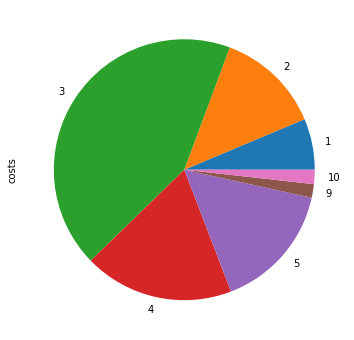

In [59]:
costs_by_source.plot(kind='pie', figsize=(6, 6))

Большая часть расходов пошла источник под кодом 3, чем бы это ни было.


Посчитаем расходы по месяцам. Для этого выделим месяц в отдельный столбец.

In [60]:
costs['cost_month'] = costs['cost_ts'].dt.strftime('%Y-%m')

In [61]:
costs_by_month = costs.groupby('cost_month')['costs'].sum()
costs_by_month

cost_month
2017-06    18015.00
2017-07    18240.59
2017-08    14790.54
2017-09    24368.91
2017-10    36322.88
2017-11    37907.88
2017-12    38315.35
2018-01    33518.52
2018-02    32723.03
2018-03    30415.27
2018-04    22289.38
2018-05    22224.27
Name: costs, dtype: float64

Визуализируем.

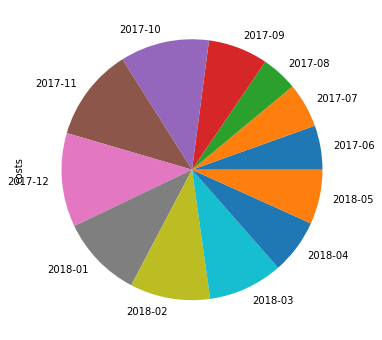

In [62]:
costs_by_month.plot(kind='pie', figsize=(6, 6))

В условно холодное время года расходы на маркетинг выше. Возможно, в этот период люди не очень хотят выходить из дома, и требуется больше ресурсов, чтобы сподвигнуть их на покупку билета. При этом месячное количество пользователей в эти месяцы также вырастает, что мы уже видели на графике для MAU. Дают ли увеличенные расходы и прирост пользователей результат в виде прибыли, узнаем далее.

### Стоимость привлечения одного покупателя по каждому источнику

Изучим, сколько стоит привлечь одного покупателя из каждого источника. Информация об источнике перехода есть в таблице visits, информация о факте покупки - в таблице orders. Клиент - это пользователь, совершивший покупку, то есть его uid должен быть в таблице orders. За источник привлечения возьмем источник, из которого пользователь начал первую сессию.

Используем объединенные таблицы orders и visits, чтобы дальше делать по ним срез. Добавим дату первой сессии.

In [63]:
orders_visits = pd.merge(orders_visits, first_visits, on='uid')
orders_visits.head()

,buy_ts,revenue,uid,device,end_ts,source_id,start_ts,session_year,session_month,session_week,session_date,session_duration_sec,first_visit_ts
0,2017-06-01 00:10:00,17.00,10329302124590727494,desktop,2017-06-01 00:11:00,1,2017-06-01 00:09:00,2017,6,22,2017-06-01,120,2017-06-01 00:09:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,desktop,2017-06-01 00:25:00,2,2017-06-01 00:14:00,2017,6,22,2017-06-01,660,2017-06-01 00:14:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,desktop,2017-06-01 00:34:00,2,2017-06-01 00:25:00,2017,6,22,2017-06-01,540,2017-06-01 00:25:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,desktop,2017-06-01 00:33:00,2,2017-06-01 00:14:00,2017,6,22,2017-06-01,1140,2017-06-01 00:14:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,desktop,2017-06-01 07:59:00,3,2017-06-01 07:31:00,2017,6,22,2017-06-01,1680,2017-06-01 07:31:00


Сделаем срез по условию, что сессия - первая, и посчитаем количество клиентов по каждому источнику.

In [64]:
source_cnt = orders_visits.query('start_ts == first_visit_ts').groupby('source_id').agg({'uid': 'nunique'})
source_cnt

,uid
source_id,
1,2899
2,3506
3,10473
4,10296
5,6931
7,1
9,1088
10,1329


Построим визуализацию.

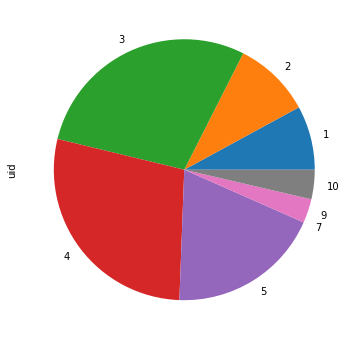

In [65]:
source_cnt['uid'].plot(kind='pie', figsize=(6, 6))

Больше всего клиентов пришло из источников 3, 4. Источник 5 тоже неплох. К источнику 7 есть вопросы - с него за год пришел всего 1 клиент. Либо у данного источника большой потенциал к улучшению, либо он появился недавно, либо в отправке статистики баг (что наиболее вероятно).

Посчитаем стоимость привлечения одного клиента. Объединим таблицы с расходами на каждый источник и с количеством клиентов по каждому источнику. 

In [66]:
cost_per_client = pd.merge(source_cnt, costs_by_source, on='source_id').reset_index()
cost_per_client.columns = ['source_id', 'n_buyers', 'costs']
cost_per_client

,source_id,n_buyers,costs
0,1,2899,20833.27
1,2,3506,42806.04
2,3,10473,141321.63
3,4,10296,61073.60
4,5,6931,51757.10
5,9,1088,5517.49
6,10,1329,5822.49


Рассчитаем стоимость привлечения одного клиента.

In [67]:
cost_per_client['cost_per_client'] = cost_per_client['costs'] / cost_per_client['n_buyers']
cost_per_client

,source_id,n_buyers,costs,cost_per_client
0,1,2899,20833.27,7.186364
1,2,3506,42806.04,12.209367
2,3,10473,141321.63,13.493901
3,4,10296,61073.60,5.931779
4,5,6931,51757.10,7.467479
5,9,1088,5517.49,5.071222
6,10,1329,5822.49,4.381106


Оценим разницу на графике.

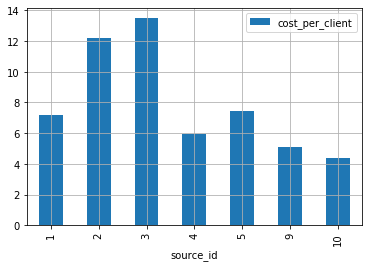

In [68]:
cost_per_client.plot(kind='bar', x='source_id', y='cost_per_client', grid=True, figsize=(6, 4))

Источник 3 оказался еще и самым дорогим. А вот источник 4 приносит много клиентов, но стоимость привлечения каждого гораздо ниже. Кстати, на источник 7 ничего не потратили. В дальнейшем оценим окупаемость каждого источника.



### На сколько окупились расходы? (ROI)

Посчитаем ROI за весь период.

In [69]:
roi_total = orders['revenue'].sum() / costs['costs'].sum()
roi_total

0.7658249304639888

Похоже, на маркетинг продукт тратит больше, чем зарабатывает.

Оценим ROI в динамике по когортам. Присоединим к отчету траты в месяц.

In [70]:
report_new = pd.merge(report, costs_by_month, left_on='first_order_month', right_on='cost_month')
report_new.head()

,first_order_month,n_buyers,order_month,revenue,age,ltv,costs
0,2017-06,2023,2017-06,9557.49,0,4.724414,18015.0
1,2017-06,2023,2017-07,981.82,1,0.485329,18015.0
2,2017-06,2023,2017-08,885.34,2,0.437637,18015.0
3,2017-06,2023,2017-09,1931.30,3,0.954671,18015.0
4,2017-06,2023,2017-10,2068.58,4,1.022531,18015.0


Рассчитаем стоимость привлечения одного клиента и ROI.

In [71]:
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new['roi'] = report_new['ltv'] / report_new['cac']
report_new.head()

,first_order_month,n_buyers,order_month,revenue,age,ltv,costs,cac,roi
0,2017-06,2023,2017-06,9557.49,0,4.724414,18015.0,8.905091,0.530530
1,2017-06,2023,2017-07,981.82,1,0.485329,18015.0,8.905091,0.054500
2,2017-06,2023,2017-08,885.34,2,0.437637,18015.0,8.905091,0.049145
3,2017-06,2023,2017-09,1931.30,3,0.954671,18015.0,8.905091,0.107205
4,2017-06,2023,2017-10,2068.58,4,1.022531,18015.0,8.905091,0.114825


Построим отчет.

In [72]:
output = report_new.pivot_table(
   index='first_order_month',
   columns='age',
   values='roi',
   aggfunc='mean')

output.cumsum(axis=1).round(2).fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,
2017-08,0.49,0.53,0.57,0.61,0.66,0.68,0.7,0.74,0.77,0.78,,
2017-09,0.60,0.72,0.77,1.19,1.23,1.3,1.38,1.4,1.42,,,
2017-10,0.60,0.66,0.68,0.7,0.72,0.74,0.75,0.76,,,,
2017-11,0.55,0.6,0.62,0.65,0.67,0.68,0.69,,,,,
2017-12,0.54,0.57,0.68,0.8,0.84,0.87,,,,,,
2018-01,0.42,0.45,0.48,0.49,0.5,,,,,,,
2018-02,0.46,0.49,0.5,0.51,,,,,,,,


Окупились только две когорты: июньская на 6 месяце и чудесная сентябрьская на 3 месяце. Либо это самые лояльные пользователи, которые стерпят даже рассылку про брошеную корзину, либо в эти когорты затесались перекупы.



Оценим ROI по источникам. Посчитаем, сколько каждый источник принес денег.

In [73]:
source_revenue = orders_visits.query('start_ts == first_visit_ts').groupby('source_id').agg({'revenue': 'sum'})
source_revenue

,revenue
source_id,
1,31090.55
2,46923.61
3,54511.24
4,56696.83
5,52624.02
7,1.22
9,5759.40
10,4450.33


Объединим с затратами на каждый источник.

In [74]:
source_roi = pd.merge(costs_by_source, source_revenue, on='source_id')
source_roi

,costs,revenue
source_id,,
1,20833.27,31090.55
2,42806.04,46923.61
3,141321.63,54511.24
4,61073.60,56696.83
5,51757.10,52624.02
9,5517.49,5759.40
10,5822.49,4450.33


Рассчитаем отношение прибыли к затратам.

In [75]:
source_roi['roi'] = source_roi['revenue'] / source_roi['costs']
source_roi

,costs,revenue,roi
source_id,,,
1,20833.27,31090.55,1.492351
2,42806.04,46923.61,1.096191
3,141321.63,54511.24,0.385725
4,61073.60,56696.83,0.928336
5,51757.10,52624.02,1.016750
9,5517.49,5759.40,1.043844
10,5822.49,4450.33,0.764335


Оценим ROI на графике.

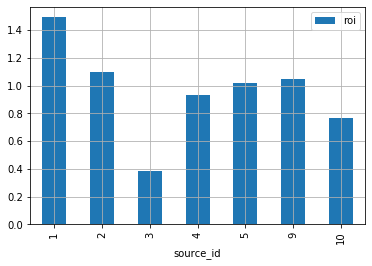

In [76]:
source_roi['roi'].plot(kind='bar', grid=True, figsize=(6, 4), legend=True)

Лучше всего окупается источник 1. Источники 3, 4 и 10 не окупаются. При этом источник 3, на который уходит больше всего бюджета, имеет худший показатель ROI.



### Вывод

Общие раходы за период - 329131.62 тыс.руб.

Большая часть расходов пошла источник под кодом 3, чем бы это ни было.

В условно холодное время года расходы на маркетинг выше. Возможно, в этот период люди не очень хотят выходить из дома, и требуется больше ресурсов, чтобы сподвигнуть их на покупку билета.

Источник 3 приносит больше всего клиентов, однако имеет самую большую стоимость привлечения одного клиента. А вот источник 4 приносит много клиентов, но стоимость привлечения каждого гораздо ниже. 

Лучше всего окупается источник 1. Источники 3, 4 и 10 не окупаются. При этом источник 3, на который уходит больше всего бюджета, имеет худший показатель ROI.

Источники 1, 2, 5 и 9 окупаются, при этом источник 1 - лучше всех.
Больше всего клиентов из источников 3, 4, 5.
Наименьшая стоимость привлечения одного клиента у источников 10, 9, 4, 1, 5








Был проведен анализ данных от Яндекс.Афиши за период в год: с июня 2017 по конец мая 2018 года. Использовались данные:
* лог сервера с данными о посещениях сайта Яндекс.Афиши,
* выгрузка всех заказов за этот период,
* статистика рекламных расходов.

По результатам анализа было определено, как люди пользуются продуктом; когда они начинают покупать; сколько денег приносит каждый клиент; когда клиент окупается.

#### Как люди пользуются продуктом

Пользовательская активность за период:
* DAU = 907.99, 
* WAU = 5716.25, 
* MAU = 23228.42.

Среднее количество сессий в день на пользователя: 1.08 шт.

Средняя продолжительность сессии: ASL = 60 секунд.

Возвращение пользователей к продукту:
* 15.9% пользователей возвращаются в течение недели,
* 3.9% - в течение месяца.

#### Когда пользователи начинают покупать

Характерное значение промежутка между первым визитом и первым заказом - 16 минут. При том, что самая частотная длительность сессии - 60 с, скорее всего в такие сессии покупки не совершают. Откуда пришли эти пользователи -> проработать источник.


#### Cколько денег приносит каждый клиент

Большинство пользователей делали по одному заказу за период в год. Медианный средний чек - 2500 рублей, средний чек - 4090. Такие цифры похожи на билеты в театр или на концерт. -> продвигать именно театры и концерты, не кино.

Если смотреть в разрезе когорт, то пользователи приносят наиболее количество денег в 0 месяц lifetime. Это соотносится и с покупкой раз в год, и с величиной среднего чека.

#### Когда клиент окупается

Общие раходы за период - 329131.62 тыс.руб.

Большая часть расходов пошла источник под кодом 3, чем бы это ни было.

В условно холодное время года расходы на маркетинг выше. Возможно, в этот период люди не очень хотят выходить из дома, и требуется больше ресурсов, чтобы сподвигнуть их на покупку билета.

Источник 3 приносит больше всего клиентов, однако имеет самую большую стоимость привлечения одного клиента. А вот источник 4 приносит много клиентов, но стоимость привлечения каждого гораздо ниже. 

Лучше всего окупается источник 1. Источники 3, 4 и 10 не окупаются. При этом источник 3, на который уходит больше всего бюджета, имеет худший показатель ROI.

## Шаг 3. Выводы и рекомендации 

Составим рекомендации маркетологам, куда им стоит вкладывать деньги.

#### В какой источник вкладывать деньги

Приведем еще раз графики по источникам, с которых приходят клиенты. Соотнесем окупаемость и стоимость привлечения одного клиента.

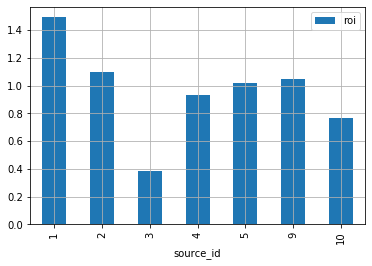

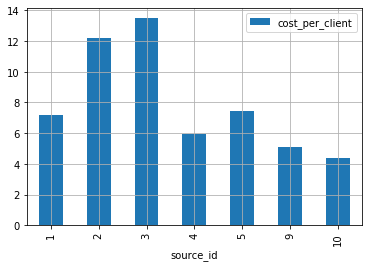

In [77]:
source_roi['roi'].plot(kind='bar', grid=True, figsize=(6, 4), legend=True)
cost_per_client.plot(kind='bar', x='source_id', y='cost_per_client', grid=True, figsize=(6, 4))

Источник 3 имеет наибольшую стоиомость привлечения одного клиента, при этом далек от окупаемости. В то же время именно на него маркетинг расходует наибольшую сумму.

Окупаются источники 1, 2, 5 и 9. При этом источник 2 имеет достаточно высокую стоимость привлечения клиентов.

Исходя из этих метрик рекомендация - снизить бюджет на источник 3 и направить его на источники 1 и 9. Это источники с наилучшей окупаемостью и наименьшей стоимостью привлечения клиента при условии окупаемости источника.

#### Какие платформы следует развивать

У нас нет данных о мобильном приложении Яндекс.Афишы, поэтому сравниваем только десктопную и мобильную версии сайта.

Месячная аудитория десктопа в 2,5 раза выше, чем мобильного сайта:

In [78]:
mau_desktop

uid    16724.916667
dtype: float64

In [79]:
mau_touch

uid    6825.916667
dtype: float64

Прибыль с десктопа в 12,5 раз выше, чем с мобильного сайта:

In [80]:
revenue_total_desktop

6447893.990000001

In [81]:
revenue_total_touch

514313.36

Отсюда рекомендация - вложить больше ресурсов в развитие основной версии сайта.

